In [1]:
%matplotlib notebook
import jplus
import os
import pickle
import elgtools
import numpy as np
import matplotlib.pyplot as plt
import Read_Mocks as read
import MockJPLUS as mtools

Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/'
namelc   = 'LightCone_SA_0_'

In [2]:
# Loading Lightcone galaxies
nCone = 512
lcone = []
print 'reading Lightcone...'
for i in range(nCone): #nCone):
    nameIn = '%s%s%d' % (Mockpath, namelc, i)
    ilc = read.readmock_chunk_PythonCut(nameIn, zspace = True)
    lcone.append(ilc[0])
    
dcone = np.concatenate(lcone)


reading Lightcone...


In [14]:
# Loading J-PLUS candidates


elgdir   = os.getcwd()
fout = '%s/out/elgs.dat' % elgdir
z_oii = [0.73, 0.79]
LoadJPLUSCat = True # if True loads a ELG catalogue of JPLUS already built

if LoadJPLUSCat:
    gal_elgs = pickle.load(open(fout))
else:
    mag_excess = "AND (m.MAG_APER_3_0[jplus::rSDSS]- m.MAG_APER_3_0[jplus::J0660]) > 0"
    gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type="aperMags", overwrite=False, 
                                                 object_name="allELGs", nchunks=10, mag_limit=[16,24],
                                                extra_where_conds=mag_excess,db='upad')
    ijlim = 0.4
    rjlim = 0.4
    gal_elgs = elg.make_selection(gal_jplus,ijlim = ijlim, rjlim = rjlim, makeplot= False)


    with open(fout,'wb') as outfile:
        pickle.dump(gal_elgs,outfile,protocol=pickle.HIGHEST_PROTOCOL)

    
elgtiles = np.unique(gal_elgs['tile_id'])
print 'J-PLUS ELG catalogue loaded'

print dcone.dtype
print dcone['ObsMagDust'][:,11]

J-PLUS ELG catalogue loaded
[('Type', '<i4'), ('Mvir', '<f4'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('sfr', '<f4'), ('sfr_inst', '<f4'), ('BulgeMass', '<f4'), ('DiskMass', '<f4'), ('Time', '<f4'), ('redshift', '<f4'), ('BlackholeMass', '<f4'), ('MetalColdGas', '<f4'), ('ColdGas', '<f4'), ('MassWeightAge', '<f4'), ('ObsMagDust', '<f4', (12,))]
[-24.18241501 -24.18241119 -24.18241119 ..., -21.16036224 -22.26612473
 -21.33590698]


Computing 3FM on mocks and J-PLUS ...
done


<IPython.core.display.Javascript object>


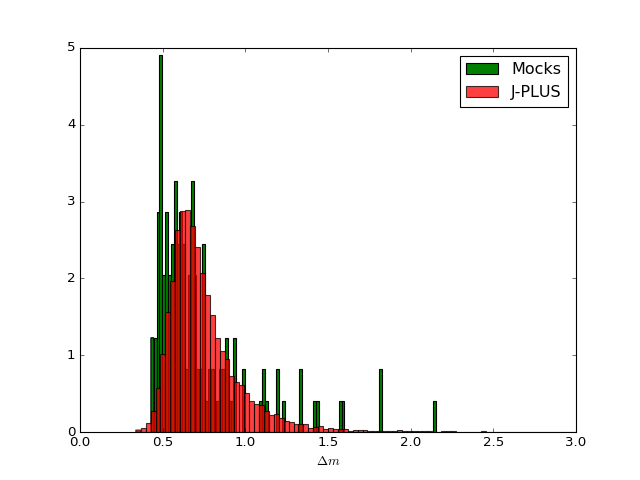

In [17]:
delta_min = 0.3
print 'Computing 3FM on mocks and J-PLUS ...'

r_mock     = dcone['ObsMagDust'][:,mtools.name_to_num['rSDSS']]
i_mock     = dcone['ObsMagDust'][:,mtools.name_to_num['iSDSS']]
g_mock     = dcone['ObsMagDust'][:,mtools.name_to_num['gSDSS']]
J0660_mock = dcone['ObsMagDust'][:,mtools.name_to_num['J0660']]

dcond = (r_mock - J0660_mock > 0.4) & (i_mock - J0660_mock > 0.4) 

dm_mocks = mtools.tfm(dcone[dcond])
dm_jplus = mtools.gen_3fm(gal_elgs['J0660'][:,0], gal_elgs['rJAVA'][:,0], gal_elgs['iJAVA'][:,0])
print 'done'

plt.hist(dm_mocks,100,normed=True,facecolor='green',label='Mocks')
plt.hist(dm_jplus,100,normed=True,facecolor='red',alpha=0.75,label='J-PLUS')
plt.xlim([0,3])
plt.xlabel(r'$\Delta m$')
plt.legend(loc='upper right')



In [ ]:
plt.plot(dcone['pos'][:,0],dcone['pos'][:,1],',')

In [ ]:
print gal_elgs